In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import pandas as pd

In [3]:
train_df = pd.read_csv("data/train.csv", index_col="id")
val_df = pd.read_csv("data/val.csv", index_col="id")
test_df = pd.read_csv("data/test.csv", index_col="id")

print("train size", len(train_df))
print("val size", len(val_df))
print("test size", len(test_df))

train size 31500
val size 2700
test size 10800


In [4]:
train_df.sample(10)

,text,label
id,,
26381,2D orientation scores $U: mathbbR 3 times S ...,3
23686,"sphere flipping, a one-one invertible nonlinea...",2
1971,general loss functions and class of predictors...,1
19952,the sample complexity of active learning under...,1
26483,two color spaces are investigated: RGB and CIE...,3
7037,control funnel functions are a fundamental pro...,2
15251,"in this paper, we consider the problem of subs...",3
15724,policy gradient methods are widely used in rei...,1
11468,graph theoretic approach is proposed for objec...,3


<AxesSubplot:>

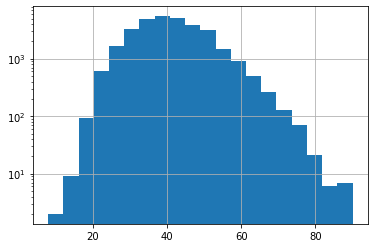

In [5]:
text_lengths = train_df["text"].apply(lambda x: len(x.split()))
text_lengths.hist(log=True, bins=20)

<AxesSubplot:>

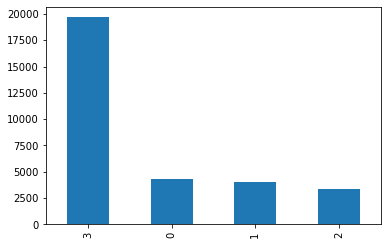

In [6]:
train_df["label"].value_counts().plot(kind="bar")

<AxesSubplot:>

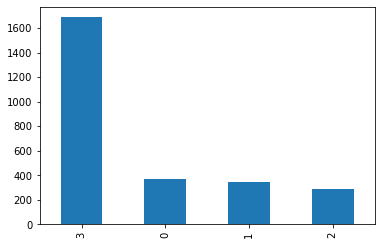

In [7]:
val_df["label"].value_counts().plot(kind="bar")

In [14]:
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding

model_name = "distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.weight'

(array([ 390., 3935., 7809., 9299., 5468., 2913., 1197.,  341.,  122.,
          26.]),
 array([ 22. ,  30.6,  39.2,  47.8,  56.4,  65. ,  73.6,  82.2,  90.8,
         99.4, 108. ]),
 <BarContainer object of 10 artists>)

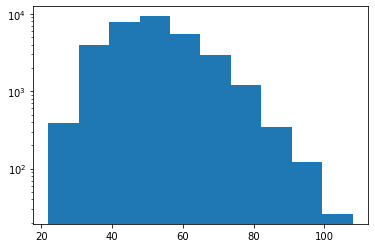

In [9]:
import matplotlib.pyplot as plt

tokenized_train = tokenizer(train_df["text"].to_list()).input_ids
lengths = [len(x) for x in tokenized_train]

plt.hist(lengths, log=True)

In [10]:
tokenized_train = tokenizer(train_df["text"].to_list(), max_length=256, truncation=True)
tokenized_val = tokenizer(val_df["text"].to_list(), max_length=256, truncation=True)
tokenized_test = tokenizer(test_df["text"].to_list(), max_length=256, truncation=True)

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, tokenized_text, labels):
        self.tokenized_text = tokenized_text
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k,v in self.tokenized_text.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
train_dataset = TextDataset(tokenized_train, train_df["label"].to_list())
val_dataset = TextDataset(tokenized_val, val_df["label"].to_list())
test_dataset = TextDataset(tokenized_test, test_df["label"].to_list())

In [12]:
import numpy as np

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    preds = np.argmax(preds, axis=-1)

    acc = (preds == labels).astype(np.float32).sum() / len(labels)
    return {"acc": acc}

In [15]:
training_args = TrainingArguments(
    output_dir="results",
    logging_dir="logs",
    num_train_epochs=10,
    warmup_ratio=0.1,
    per_device_train_batch_size=256,
    per_device_eval_batch_size=256,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_first_step=True,
    logging_steps=10,
    fp16=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

Epoch,Training Loss,Validation Loss


TrainOutput(global_step=1240, training_loss=0.2533327483361767, metrics={'train_runtime': 305.7588, 'train_samples_per_second': 4.055, 'total_flos': 0, 'epoch': 10.0})

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = AutoModelForSequenceClassification.from_pretrained("results/checkpoint-496")
model = model.to(device)
model = model.eval()

In [17]:
test_dataloader = DataLoader(test_dataset, batch_size=256, collate_fn=data_collator)

In [18]:
results = []

with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k,v in batch.items()}
        output = model(**batch)
        results.append(output["logits"].cpu())

In [19]:
results = torch.cat(results)
results = torch.argmax(results, dim=1)
results

tensor([3, 2, 3,  ..., 1, 0, 3])

In [20]:
submission = test_df.copy()
submission["label"] = results.numpy()
submission

,text,label
id,,
0,we propose a lightweight framework to detect i...,3
1,the proposed method presents an alternate solu...,2
2,proposed ear identification method fusing SIFT...,3
3,a method to reconstruct the three-dimensional ...,3
4,strong local consistencies can improve their p...,0
...,...,...
10795,whole-body gradient echo scans of 240 subjects...,3
10796,we present a tracker that accomplishes trackin...,3
10797,the most popular FL algorithm is Federated Ave...,1


In [21]:
submission.to_csv("submission.csv")